# Introduction

Topic: We will collect I-V data of a LED

# Connection

![Electrical Connections](../extra/img/fritzing/led-iv-curve_bb.png)

```
AOUT0.CH0---.          .------------- AIN0.CH1
           |          |
AIN0.CH0 ------/\/\/\------|>|------- GND
                 R1        D1          
                                   
R1 = 320
D1 = [RED] LED
```

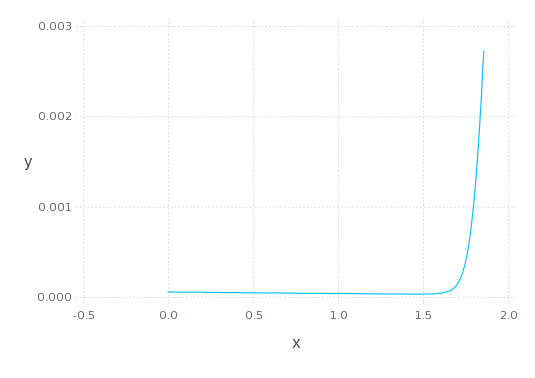

In [1]:
import Box0
import Gadfly

# allocate the appropriate resources
dev = Box0.Usb.open_supported()
ain0 = Box0.ain(dev)
aout0 = Box0.aout(dev)

# prepare AIN0
Box0.snapshot_prepare(ain0)
Box0.chan_seq_set(ain0, Array{Cuint}([0, 1]))
Box0.bitsize_speed_set(ain0, Cuint(12), Culong(100000))

# prepare AOUT0
Box0.snapshot_prepare(aout0)

# generate voltage, read voltage, calculate current and store the result
# AIN0.CH0 = AOUT0.CH0 = generated signal
# AIN0.CH1 = voltage across LED
# current  = (AIN0.CH0 - AIN0.CH1) / R1  (where R1 = 320)
const R1 = 320.0
const SAMPLES = 100
x = Array{Float32}(SAMPLES)
y = Array{Float32}(SAMPLES)

voltages = linspace(0.0, 3.3, SAMPLES)
aout0_running = false

for i in range(1, SAMPLES)
    if aout0_running
        Box0.snapshot_stop(aout0)
    end
    
    # output "v" value on AOUT0.CH0
    Box0.snapshot_start(aout0, Array(voltages[i:i]))
    aout0_running = true
    
    # read back AIN.CH0 and AIN0.CH1
    readed_data = Array{Float32}(SAMPLES)
    Box0.snapshot_start(ain0, readed_data)
    
    # do the calculation
    ch0 = mean(readed_data[1:2:length(readed_data)])
    ch1 = mean(readed_data[2:2:length(readed_data)]) # = voltage across LED
    current = (ch0 - ch1)/R1
    
    # store the result
    x[i] = ch1
    y[i] = current
end

# stop if AOUT0 running
if aout0_running
    Box0.snapshot_stop(aout0)
end

# close the resources
Box0.close(ain0)
Box0.close(aout0)
Box0.close(dev)

# now, plot the data
Gadfly.plot(x=x,y=y, Gadfly.Geom.line)